In [7]:
from preprocessing.data_cleaning import get_cleaned_data, split_csv, get_features_label
from preprocessing.encoding import encode_data
from exploration.data_correlations import plot_correlations
from exploration.data_statistics import plot_patientwise_errors, plot_labels_pie_chart, plot_blood_draw_statistics
from exploration.midterm_exploration import plot_feature_against_diagnosis
from utils.utils import log_features
from modeling.mrmr import perform_mrmr

In [8]:
df = encode_data(get_cleaned_data())
df = df[df["P1_PT_TYPE"] != 3]
log_features(df)
blood, clinical = split_csv(df)

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (4).

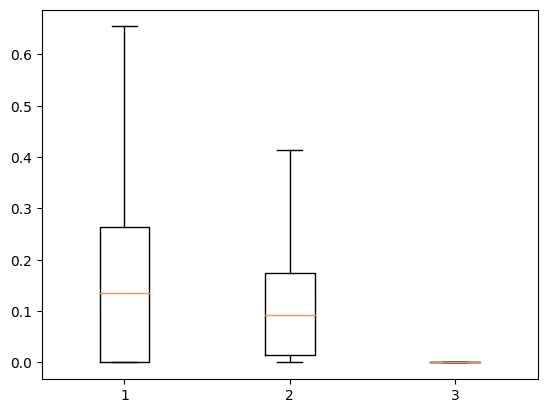

In [9]:
plot_patientwise_errors(
    df,
    ["C1_WAIS3_DIGTOT", "B1_BMI", "RBM_Insulin"],
    ["Race", "WAIS3 Digits Score", "BMI", "Insulin"],
    png="Patientwise Errors"
)

In [ ]:
plot_labels_pie_chart(df, png="Pie Chart of Diagnoses")

In [ ]:
plot_blood_draw_statistics(df, png="Blood Draw Proportions")

In [ ]:
plot_correlations(df)

In [10]:
import pandas as pd

y, X = get_features_label(df)
y = pd.Series(y)
features = perform_mrmr(X, y, 10)

100%|██████████| 14/14 [00:02<00:00,  5.69it/s]


C1_CDRSUM          12246.970442
C1_CDRGLOB         10823.582862
C1_MMSE             7494.683432
F2_IADLTOTSCR       5185.036349
C1_WMS3_LMEM2       5028.276859
C1_WMS3_LMEM1       4529.604559
C1_SS_TRAILB        3959.703523
C1_WMS3_VRI         3419.329063
C1_SS_TRAILA        2340.337211
PATID               1626.602202
F1_PSMSTOTSCR       1201.271258
AGE                 1146.880587
C1_WAIS3_DIGTOT      968.533223
A1_HISPANIC_1.0      894.116943
B5_AGITSEV_1.0       553.970459
B5_APASEV_2.0        531.921692
B5_APASEV_1.0        531.830872
B5_AGITSEV_2.0       457.116058
B1_BMI               441.619060
D1_total             436.214301
dtype: float64

In [ ]:
plot_feature_against_diagnosis(
    blood,
    "Q1_Total_tau",
    title="Total Tau Concentration by Diagnosis",
    ylabel="Total Tau Concentration (pg/mL)",
    png="Total Tau Concentration by Diagnosis"
)

In [ ]:
plot_feature_against_diagnosis(
    clinical,
    "C1_MMSE",
    title="MMSE Score by Diagnosis",
    ylabel="MMSE Score",
    png="MMSE Score by Diagnosis"
)

In [ ]:
plot_feature_against_diagnosis(
    clinical,
    "C1_WMSR_DIGTOT",
    title="WMSR Digit Span Score by Diagnosis",
    ylabel="WMSR Digit Span Score",
    png="WMSR Digit Span Score by Diagnosis"
)

In [ ]:
plot_feature_against_diagnosis(
    clinical,
    "C1_CDRSUM",
    title="CDR Score by Diagnosis",
    ylabel="CDR Score",
    png="CDR Score by Diagnosis"
)

temp = clinical[clinical["P1_PT_TYPE"] == 2]
temp["C1_CDRSUM"].value_counts()

In [ ]:
import pandas as pd
label_encoded_df = pd.get_dummies(blood, columns=["P1_PT_TYPE"])

correlations = blood.corr().abs().unstack()
ad_correlations = correlations["P1_PT_TYPE"].sort_values()
print(ad_correlations.index[:100])